In [1]:
import tensorflow as tf

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import csv
import time as t
plt.rcParams.update({'font.size': 22})

In [3]:
file_path = "../Data_acquisition/Final DB/commercial/"

In [4]:
def plot_series(time, series, format="-", start = 0, end= None):
  """
  Plot time series data in time order
  """
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

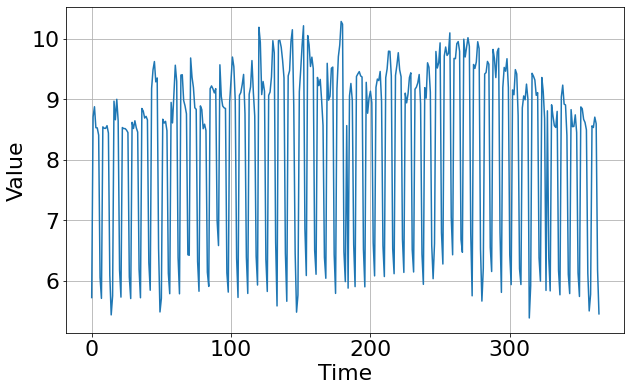

In [5]:
time_step = []
temps = []

with open(file_path + "merged_energy.csv") as csvfile:
  reader = csv.reader(csvfile,delimiter = ',')
  next(reader) #first line
  step = 0
  for row in reader:
    temps.append(float(row[3]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10,6))
plot_series(time,series)

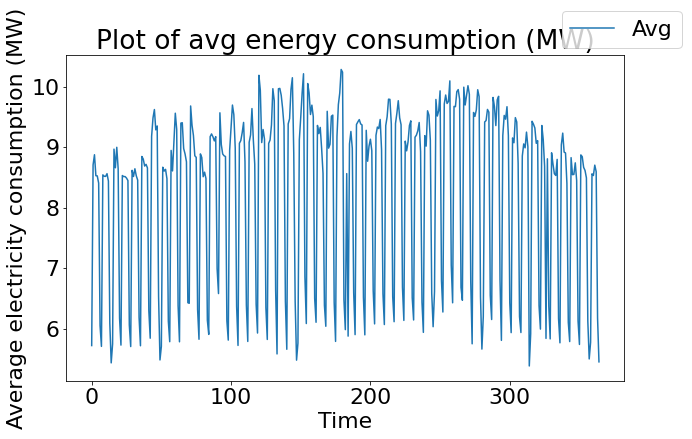

In [6]:
fig, ax1 = plt.subplots(figsize = (10,6))
ax1.plot(time, series, color = "tab:blue", label = "Avg")
#ax1.set_ylim([-5,80])
ax1.set_title("Plot of avg energy consumption (MW)")
ax1.set_ylabel("Average electricity consumption (MW)")
ax1.set_xlabel("Time")
fig.legend(loc="upper right")

In [7]:
def percentage_error(actual, prediction):
    """
    Compute the PE in MAPE
    """
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - prediction[j]) / actual[j]
        else:
            res[j] = prediction[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    """
    Compute MAPE
    """
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [8]:
# DNN

In [9]:
#Train test split 70:30
time_split = int(len(time_step)*0.7)
time_train = time[:time_split]
x_train = series[:time_split]
time_valid = time[time_split:]
x_valid = series[time_split:]

shuffle_buffer_size = len(x_train)

In [10]:
def windowed_dataset1(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

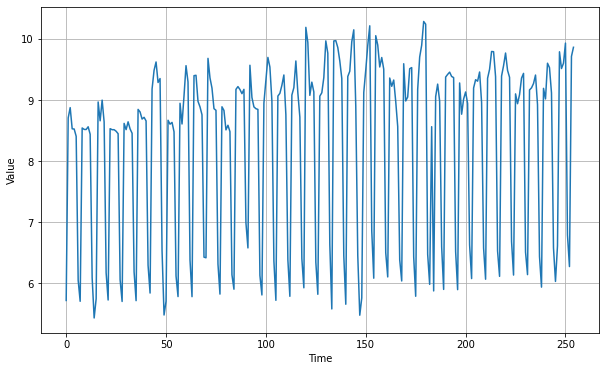

In [11]:
plt.figure(figsize=(10, 6))

plot_series(time_train, x_train)

Epoch 1/200
4/4 [==============================] - 0s 5ms/step - loss: 7.9058
Epoch 2/200
4/4 [==============================] - 0s 4ms/step - loss: 7.9057
Epoch 3/200
4/4 [==============================] - 0s 3ms/step - loss: 7.9056
Epoch 4/200
4/4 [==============================] - 0s 5ms/step - loss: 7.9054
Epoch 5/200
4/4 [==============================] - 0s 4ms/step - loss: 7.9051
Epoch 6/200
4/4 [==============================] - 0s 3ms/step - loss: 7.9048
Epoch 7/200
4/4 [==============================] - 0s 4ms/step - loss: 7.9045
Epoch 8/200
4/4 [==============================] - 0s 4ms/step - loss: 7.9041
Epoch 9/200
4/4 [==============================] - 0s 3ms/step - loss: 7.9036
Epoch 10/200
4/4 [==============================] - 0s 4ms/step - loss: 7.9031
Epoch 11/200
4/4 [==============================] - 0s 4ms/step - loss: 7.9026
Epoch 12/200
4/4 [==============================] - 0s 4ms/step - loss: 7.9019
Epoch 13/200
4/4 [==============================] - 0s 4ms/st

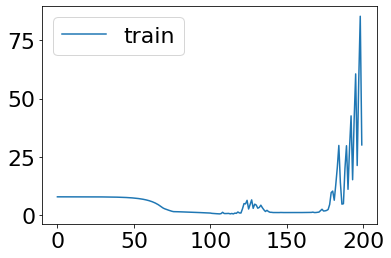

14.138854503631592


In [11]:
start = t.time()
window_size = 7
train_set = windowed_dataset1(x_train, window_size = window_size, batch_size= 64, shuffle_buffer = shuffle_buffer_size)
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(15, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10 **(epoch/20)
)

optimizer = tf.keras.optimizers.SGD(lr=1e-8,momentum=0.9)
model.compile(loss = "mae", optimizer=optimizer)
history = model.fit(train_set,epochs = 200, callbacks=[lr_schedule],verbose=1)

# plot history
plt.plot(history.history["loss"], label="train")
plt.legend()
plt.show()

print(t.time()-start)

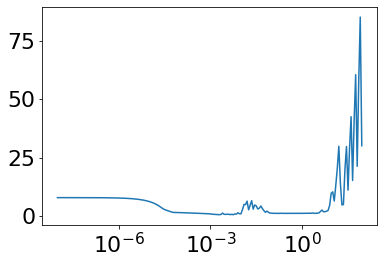

In [12]:
lrs = 1e-8 * (10 ** (np.arange(200) / 20))
plt.semilogx(lrs, history.history["loss"])

och 151/400
4/4 [==============================] - 0s 4ms/step - loss: 0.3853
Epoch 152/400
4/4 [==============================] - 0s 3ms/step - loss: 0.3819
Epoch 153/400
4/4 [==============================] - 0s 4ms/step - loss: 0.3840
Epoch 154/400
4/4 [==============================] - 0s 4ms/step - loss: 0.4067
Epoch 155/400
4/4 [==============================] - 0s 4ms/step - loss: 0.4404
Epoch 156/400
4/4 [==============================] - 0s 4ms/step - loss: 0.4055
Epoch 157/400
4/4 [==============================] - 0s 4ms/step - loss: 0.3980
Epoch 158/400
4/4 [==============================] - 0s 3ms/step - loss: 0.3882
Epoch 159/400
4/4 [==============================] - 0s 4ms/step - loss: 0.3947
Epoch 160/400
4/4 [==============================] - 0s 3ms/step - loss: 0.3840
Epoch 161/400
4/4 [==============================] - 0s 4ms/step - loss: 0.4030
Epoch 162/400
4/4 [==============================] - 0s 4ms/step - loss: 0.4791
Epoch 163/400
4/4 [=======================

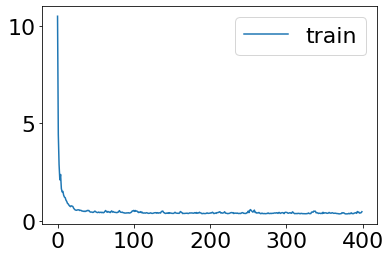

26.589919328689575


In [13]:
start = t.time()
window_size = 7
train_set = windowed_dataset1(x_train, window_size = window_size, batch_size= 64, shuffle_buffer = shuffle_buffer_size)
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(15, activation="relu"), 
    tf.keras.layers.Dense(1)
])



optimizer = tf.keras.optimizers.SGD(lr=1e-3,momentum=0.9)
model.compile(loss = "mae", optimizer=optimizer)
history = model.fit(train_set,epochs = 400,verbose=1)

# plot history
plt.plot(history.history["loss"], label="train")
plt.legend()
plt.show()

print(t.time()-start)

In [15]:
start = t.time()
forecast = []

for time in range(len(series)-window_size):
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))

forecast = forecast[time_split-window_size:]
results = np.array(forecast)[:,0,0]

print(t.time()-start)

13.385258674621582


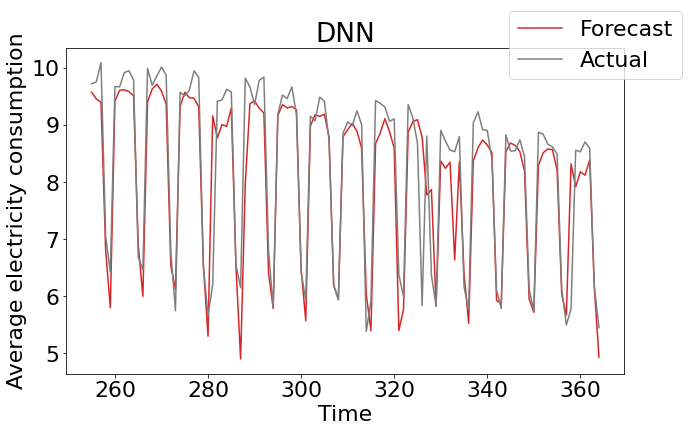

In [18]:
fig, ax1 = plt.subplots(figsize = (10,6))
ax1.plot(time_valid, results, color = "tab:red", label = "Forecast")
ax1.plot(time_valid, x_valid, color = "tab:grey", label = "Actual")
#ax1.set_ylim([-5,80])
ax1.set_title("DNN")
ax1.set_ylabel("Avg electricity consumption [MW]")
ax1.set_xlabel("Time")
fig.legend(loc="upper right")

In [20]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

0.40729564

In [21]:
mean_absolute_percentage_error(x_valid,results)

5.555807642880913